In [2]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 23.24 MiB/s, done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-dzhm7r6d
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-dzhm7r6d
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.1-py3-none-any.whl size=125700 sha256=2a228997aba78d8e78c0d1652f2d067ecb9bbac50e1cd90ed2b4dd38b5dcbec2
  Stored in directory: /tmp/pip-ephem-wheel-cache-ul5ge0jh/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully bu

In [3]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [5]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'

DEVICE = 'cuda'
BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [6]:
data = pd.read_csv(CSV_FILE)
data.head() # Cucumber - 0, Eggplant - 1, Mushroom - 2

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [7]:
train_df, valid_df = train_test_split(data, test_size = 0.2, random_state =42)

# Augmentations

In [8]:
train_augs = A.Compose([
              A.Rotate(),
              A.HorizontalFlip(p=0.5),
              A.VerticalFlip(p=0.5),
              A.Normalize(mean= [0.485, 0.456, 0.406],
                              std= [0.229, 0.224, 0.225])
])

valid_augs = A.Compose([
              A.Normalize(mean= [0.485, 0.456, 0.406],
                          std= [0.229, 0.224, 0.225])
])

# Load Image Dataset

In [9]:
trainset = utils.ImageDataset(train_df, augs = train_augs, data_dir = DATA_DIR)
validset = utils.ImageDataset(valid_df, augs = valid_augs, data_dir = DATA_DIR)

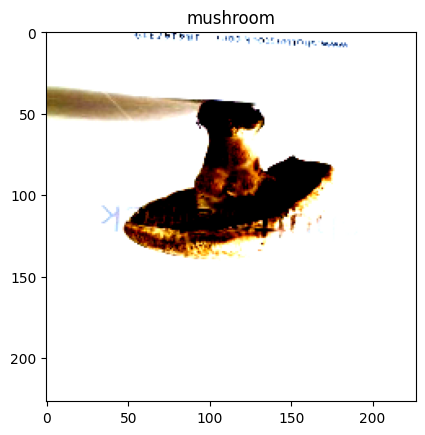

In [10]:
image, label = trainset[16] # (c, h, w) -> (h, w, c)

class_list = ['cucumber', 'eggplant', 'mushroom']
plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label]);

In [11]:
print(f'No. of examples in the trainset: {len(trainset)}')
print(f'No. of examples in the validset: {len(validset)}')

No. of examples in the trainset: 148
No. of examples in the validset: 38


# Load Dataset into Batches

In [12]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [13]:
print(f'No. of batches in trainloader: {len(trainloader)}')
print(f'No. of batches in validloader: {len(validloader)}')

No. of batches in trainloader: 10
No. of batches in validloader: 3


In [14]:
for images, labels in trainloader:
    break

print(f'One batch image shape: {images.shape}')
print(f'One batch label shape: {labels.shape}')

One batch image shape: torch.Size([16, 3, 227, 227])
One batch label shape: torch.Size([16])


# Create Model

In [26]:
class ImageModel(nn.Module):

    def __init__(self):
        super(ImageModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (5,5), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),

            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (5,5), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),

            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (5,5), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (4,4), stride = 2),

            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (5,5), padding = 1),
            nn.ReLU(),
        )

        self.maxpool = nn.MaxPool2d(kernel_size = (4,4), stride = 2)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3)
        )

        self.gradient = None

    def activations_hook(self, grad):
        self.gradient = grad

    def forward(self, images):

        x = self.feature_extractor(images) # activation máp

        h = x.register_hook(self.activations_hook)
        x = self.maxpool(x)
        x = self.classifier(x)

        return x

    def get_activation_gradients(self): # a1, a2, a3, ... ak
        return self.gradient

    def get_activations(self, x):  # A1, A2, A3, ... Ak
        return self.feature_extractor(x)

In [27]:
model =ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [28]:
def train_fn(dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [29]:
def eval_fn(dataloader, model, criterion):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(images)
        loss = criterion(logits, labels)

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Training Loop

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)
criterion = torch.nn.CrossEntropyLoss()

In [34]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(trainloader, model, optimizer, criterion)
    valid_loss = eval_fn(validloader, model, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_weights.pt')
        best_valid_loss = valid_loss
        print('SAVED')

    print(f'Epoch: {i + 1} Train Loss: {train_loss} Valid Loss: {valid_loss}')

100%|██████████| 3/3 [00:00<00:00, 34.99it/s]


SAVED
Epoch: 1 Train Loss: 1.0977534532546998 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 36.20it/s]


Epoch: 2 Train Loss: 1.0996614694595337 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 23.25it/s]


Epoch: 3 Train Loss: 1.0973573207855225 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 23.30it/s]


Epoch: 4 Train Loss: 1.098998212814331 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 22.55it/s]


Epoch: 5 Train Loss: 1.0992005825042725 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 34.26it/s]


Epoch: 6 Train Loss: 1.0978700280189515 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 37.73it/s]


Epoch: 7 Train Loss: 1.0983840823173523 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 36.13it/s]


Epoch: 8 Train Loss: 1.098735761642456 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 35.80it/s]


Epoch: 9 Train Loss: 1.0973238229751587 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 37.99it/s]


Epoch: 10 Train Loss: 1.0979486942291259 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 33.15it/s]


Epoch: 11 Train Loss: 1.0971319556236268 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 37.77it/s]


Epoch: 12 Train Loss: 1.0989073514938354 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 36.04it/s]


Epoch: 13 Train Loss: 1.0973510980606078 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 36.65it/s]


Epoch: 14 Train Loss: 1.099912905693054 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 31.17it/s]


Epoch: 15 Train Loss: 1.0986450552940368 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 35.40it/s]


Epoch: 16 Train Loss: 1.0976213335990905 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 36.90it/s]


Epoch: 17 Train Loss: 1.0993823409080505 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 32.83it/s]


Epoch: 18 Train Loss: 1.0982434749603271 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 34.63it/s]


Epoch: 19 Train Loss: 1.0981754064559937 Valid Loss: 1.1045522689819336


100%|██████████| 3/3 [00:00<00:00, 33.40it/s]

Epoch: 20 Train Loss: 1.0968509435653686 Valid Loss: 1.1045522689819336


In [30]:
def get_gradcam(model, image, label, size):

    label.backward()
    gradients = model.get_activation_gradients()
    pooled_gradients = torch.mean(gradients, dim = [0, 2, 3]) # a1, a2, .. ak
    activations = model.get_activations(image).detach() # A1, A2, .. Ak

    for i in range(activations.shape[1]):
      activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (size, size))

    return heatmap

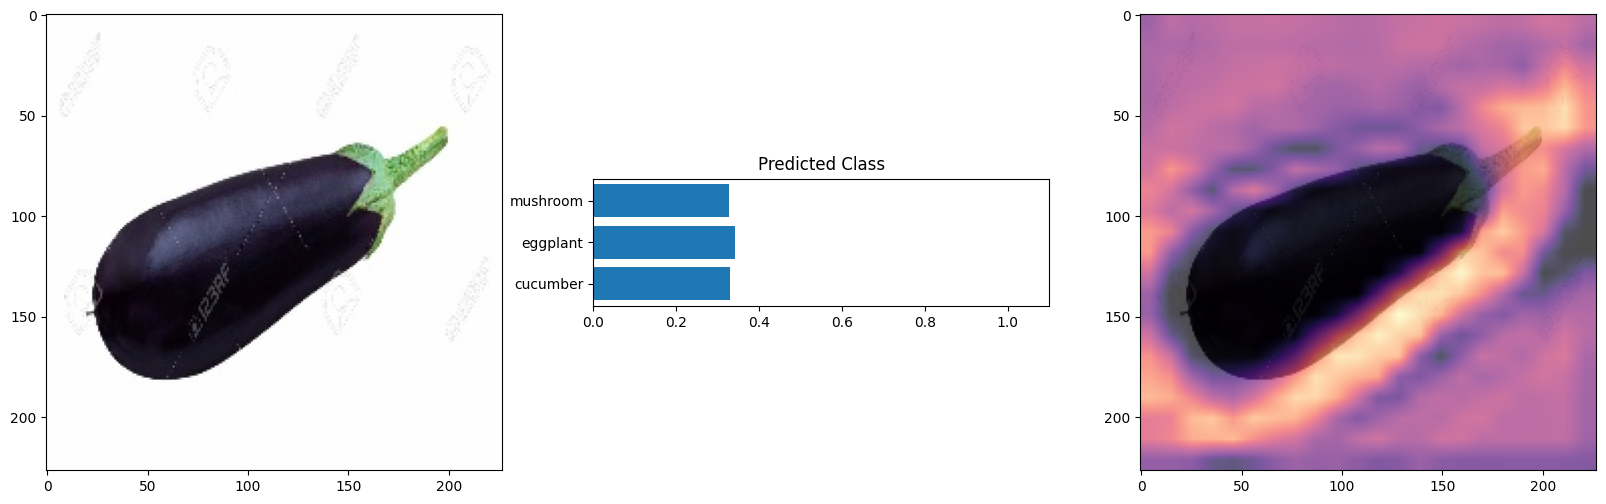

In [33]:
image, label = validset[4]

denorm_image = image.permute(1,2,0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][2],size = 227)
utils.plot_heatmap(denorm_image, pred, heatmap)